In [ ]:
import pandas as pd

base_path = r'your path'
sub_place = ['동부권', '서부권', '수도권', '제주도 및 도서지역']
sub_folder = ['TS_csv', 'VS_csv']

travel_merge = []
accomm_con_merge = []
active_con_merge = []
trans_con_merge = []
pre_con_merge = []
travler_master_merge = []

for place in sub_place:
    for folder in sub_folder:
        travel_path = base_path + "\\" + place + "\\" + folder

        suffix = {
            '동부권' : 'B',
            '서부권' : 'C',
            '수도권' : 'A',
            '제주도 및 도서지역' : 'D'
        }[place]

        travel = pd.read_csv(travel_path + f"\\tn_travel_여행_{suffix}.csv")
        accomm = pd.read_csv(travel_path + f"\\tn_lodge_consume_his_숙박소비내역_{suffix}.csv")
        active = pd.read_csv(travel_path + f"\\tn_activity_consume_his_활동소비내역_{suffix}.csv")
        trans = pd.read_csv(travel_path + f"\\tn_mvmn_consume_his_이동수단소비내역_{suffix}.csv")
        pre = pd.read_csv(travel_path + f"\\tn_adv_consume_his_사전소비내역_{suffix}.csv")

        travel_merge.append(travel)
        accomm_con_merge.append(accomm)
        active_con_merge.append(active)
        trans_con_merge.append(trans)
        pre_con_merge.append(pre)
    
    

    travel_merge_east = pd.concat(travel_merge).reset_index()
    accomm_con_merge_east = pd.concat(accomm_con_merge).reset_index()
    active_con_merge_east = pd.concat(active_con_merge).reset_index()
    trans_con_merge_east = pd.concat(trans_con_merge).reset_index()
    pre_con_merge_east = pd.concat(pre_con_merge).reset_index()

    travel_merge_east['TRAVEL_END_YMD']= pd.to_datetime(travel_merge_east['TRAVEL_END_YMD'])
    travel_merge_east['TRAVEL_START_YMD']= pd.to_datetime(travel_merge_east['TRAVEL_START_YMD'])
    travel_merge_east['TRAVEL_DAYS'] = (travel_merge_east['TRAVEL_END_YMD'] - travel_merge_east['TRAVEL_START_YMD']).dt.days

    TravelID = travel_merge_east[['TRAVEL_ID','TRAVEL_DAYS']]
    accomm_con_sel = accomm_con_merge_east[['TRAVEL_ID', 'LODGING_TYPE_CD', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON' : '숙박결제금액'})
    active_con_sel = active_con_merge_east[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON' : '활동결제금액'})
    trans_con_sel = trans_con_merge_east[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON' : '교통결제금액'})
    pre_con_sel = pre_con_merge_east[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON' : '사전결제금액'})

    accomm_drop = accomm_con_sel.drop_duplicates(subset=['TRAVEL_ID', 'LODGING_TYPE_CD', '숙박결제금액'])
    accomm_sum = accomm_drop.groupby(['TRAVEL_ID', 'LODGING_TYPE_CD'], as_index=False)['숙박결제금액'].sum()

    active_sum = active_con_sel.groupby(['TRAVEL_ID'], as_index=False)['활동결제금액'].sum()
    trans_sum = trans_con_sel.groupby(['TRAVEL_ID'], as_index=False)['교통결제금액'].sum()
    pre_con_sum = pre_con_sel.groupby(['TRAVEL_ID'], as_index=False)['사전결제금액'].sum()

    all_merge = pd.merge(TravelID, accomm_sum, on='TRAVEL_ID', how='left')
    all_merge = pd.merge(all_merge, active_sum, on='TRAVEL_ID', how='left') ## 같은 id이지만 다른 숙소유형코드에 활동결제금액 동일하게 들어감
    all_merge = pd.merge(all_merge, trans_sum, on='TRAVEL_ID', how='left') ## 같은 id이지만 다른 숙소유형코드에 교통결제금액 동일하게 들어감
    all_merge = pd.merge(all_merge, pre_con_sum, on='TRAVEL_ID', how='left') ## 같은 id이지만 다른 숙소유형코드에 사전결제금액 동일하게 들어감

    all_merge['전체결제금액'] = all_merge[['활동결제금액', '교통결제금액', '사전결제금액']].sum(axis=1, skipna=True)

    day_trip = all_merge[all_merge['LODGING_TYPE_CD'].isna()].reset_index()
    lodgment = all_merge[all_merge['LODGING_TYPE_CD'].notna()].reset_index()

    long_trip = day_trip[day_trip['TRAVEL_DAYS'] >= 3]
    lodgment = pd.concat([lodgment, long_trip], ignore_index=True)
    day_trip = day_trip[day_trip['TRAVEL_DAYS'] < 3]

    ## 여행기간이 10일 이상인 여행은 제외 -> 확인해보면 의미 없는 날짜가 포함된것들이 대다수
    day_trip = day_trip[day_trip['TRAVEL_DAYS'] < 10]
    lodgment = lodgment[lodgment['TRAVEL_DAYS'] < 10]

    lodgment = lodgment.drop_duplicates('TRAVEL_ID', keep='first')
    day_trip['전체결제금액'] = day_trip['전체결제금액'] / day_trip['TRAVEL_DAYS']
    lodgment['전체결제금액'] = lodgment['전체결제금액'] / lodgment['TRAVEL_DAYS']

    day_trip_group = day_trip[['전체결제금액']]
    lodgment_group = lodgment[['전체결제금액']]

    print(f" {place} 지역의 당일치기 여행자와 숙박여행자의 전체 결제 금액은 차이가 있다.")

    from scipy.stats import shapiro
    
    stats, pvalue = shapiro(day_trip_group)
    print("당일치기의 정규성 검증 : ", pvalue)

    stats, pvalue = shapiro(lodgment_group)
    print("숙박여행자의 정규성 검증 : ", pvalue)


    from scipy.stats import mannwhitneyu

    stat, p = mannwhitneyu(day_trip_group, lodgment_group, alternative='two-sided')
    print("mann-whitney-U 검정 : ", p[0])

    if p[0] < 0.05:
        print("당일치기 여행자와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 다르다")
    else:
        print("당일치기 여행자와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 같다.")
    print()

    ## 비모수 검정을 통해 숙박한 집단과 당일치기 집단의 전체 결제 금액 분포는 서로 유의미하게 다르다는 것을 확인하였다.


 동부권 지역의 당일치기 여행자와 숙박여행자의 전체 결제 금액은 차이가 있다.
당일치기의 정규성 검증 :  4.582896893617285e-53
숙박여행자의 정규성 검증 :  1.992339516440918e-54
mann-whitney-U 검정 :  1.801490040495694e-27
당일치기 여행자와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 다르다

 서부권 지역의 당일치기 여행자와 숙박여행자의 전체 결제 금액은 차이가 있다.
당일치기의 정규성 검증 :  4.5134667280324966e-66
숙박여행자의 정규성 검증 :  1.7584024787220537e-67
mann-whitney-U 검정 :  1.047701751089992e-42
당일치기 여행자와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 다르다

 수도권 지역의 당일치기 여행자와 숙박여행자의 전체 결제 금액은 차이가 있다.
당일치기의 정규성 검증 :  3.884474651052866e-86
숙박여행자의 정규성 검증 :  9.700142034283749e-75
mann-whitney-U 검정 :  4.12225242301809e-56
당일치기 여행자와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 다르다



c:\Users\hanaj\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6040.
  res = hypotest_fun_out(*samples, **kwds)


 제주도 및 도서지역 지역의 당일치기 여행자와 숙박여행자의 전체 결제 금액은 차이가 있다.
당일치기의 정규성 검증 :  2.3685736569076273e-88
숙박여행자의 정규성 검증 :  1.463321600325324e-85
mann-whitney-U 검정 :  1.6913110257216484e-179
당일치기 여행자와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 다르다



c:\Users\hanaj\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6623.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\hanaj\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7762.
  res = hypotest_fun_out(*samples, **kwds)


C:\Users\hanaj\AppData\Local\Temp\ipykernel_28256\3041439653.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_trip_group['구분'] = '당일치기'
C:\Users\hanaj\AppData\Local\Temp\ipykernel_28256\3041439653.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lodgment_group['구분'] = '숙박'
C:\Users\hanaj\AppData\Local\Temp\ipykernel_28256\3041439653.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

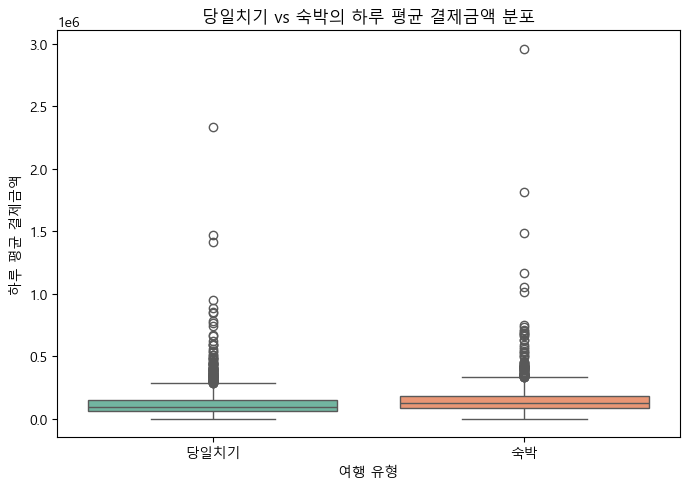

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 가정: day_trip_group과 lodgment_group은 Series 형태
day_trip_group['구분'] = '당일치기'
lodgment_group['구분'] = '숙박'

# 하나로 합치기
group_df = pd.concat([day_trip_group, lodgment_group])
group_df.columns = ['전체결제금액', '구분']

# 박스플롯 그리기
plt.figure(figsize=(7, 5))
sns.boxplot(data=group_df, x='구분', y='전체결제금액', palette='Set2')
plt.title('당일치기 vs 숙박의 하루 평균 결제금액 분포')
plt.ylabel('하루 평균 결제금액')
plt.xlabel('여행 유형')
plt.tight_layout()
plt.show()


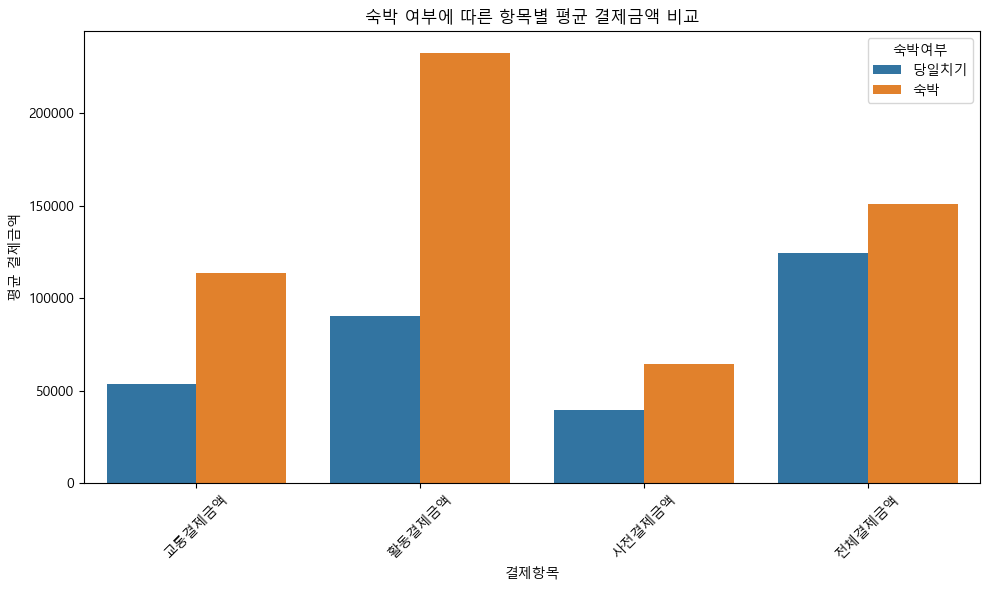

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 예: 이미 존재하는 데이터프레임을 사용 (아래는 구조 예시)
# day_trip과 lodgment는 숙박 여부에 따라 나뉜 데이터프레임이어야 함
# 각 컬럼: 숙박결제금액, 교통결제금액, 활동결제금액, 사전결제금액

day_mean = day_trip[['교통결제금액', '활동결제금액', '사전결제금액']].mean()
day_mean['전체결제금액'] = day_trip['전체결제금액'].mean()
day_mean.name = '당일치기'

lodg_mean = lodgment[['교통결제금액', '활동결제금액', '사전결제금액']].mean()
lodg_mean['전체결제금액'] = lodgment['전체결제금액'].mean()
lodg_mean.name = '숙박'

mean_df = pd.concat([day_mean, lodg_mean], axis=1).T

mean_df = pd.concat([day_mean, lodg_mean], axis=1).T

melted = mean_df.reset_index().melt(id_vars='index', var_name='결제항목', value_name='금액')
melted = melted.rename(columns={'index': '숙박여부'})

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='결제항목', y='금액', hue='숙박여부')
plt.title('숙박 여부에 따른 항목별 평균 결제금액 비교')
plt.ylabel('평균 결제금액')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [231]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 사용할 컬럼 선택
cols = ['교통결제금액', '활동결제금액', '사전결제금액','전체결제금액']
X = all_merge[cols].fillna(0)  # NaN 제거

# 정규화
X_scaled = StandardScaler().fit_transform(X)

# 클러스터링
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_scaled)
all_merge['소비유형'] = kmeans.labels_

# 각 클러스터별 평균값 확인
all_merge['클러스터'] = all_merge['소비유형']  # 클러스터 결과 붙이기
cluster_summary = all_merge.groupby('클러스터')[['교통결제금액', '활동결제금액', '사전결제금액', '전체결제금액']].mean()
display(cluster_summary)



,교통결제금액,활동결제금액,사전결제금액,전체결제금액
클러스터,,,,
0,203300.118196,435376.699531,65376.660819,651328.831008
1,60279.664964,110792.398133,37065.554839,171983.335057
2,123891.764706,223432.812500,517375.529412,851557.000000


,교통결제금액,활동결제금액,사전결제금액
소비유형,,,
0,48316.450408,90874.979774,2632.591988
1,82355.701299,188268.225108,83644.554113
2,157343.566706,318805.848878,3453.615112


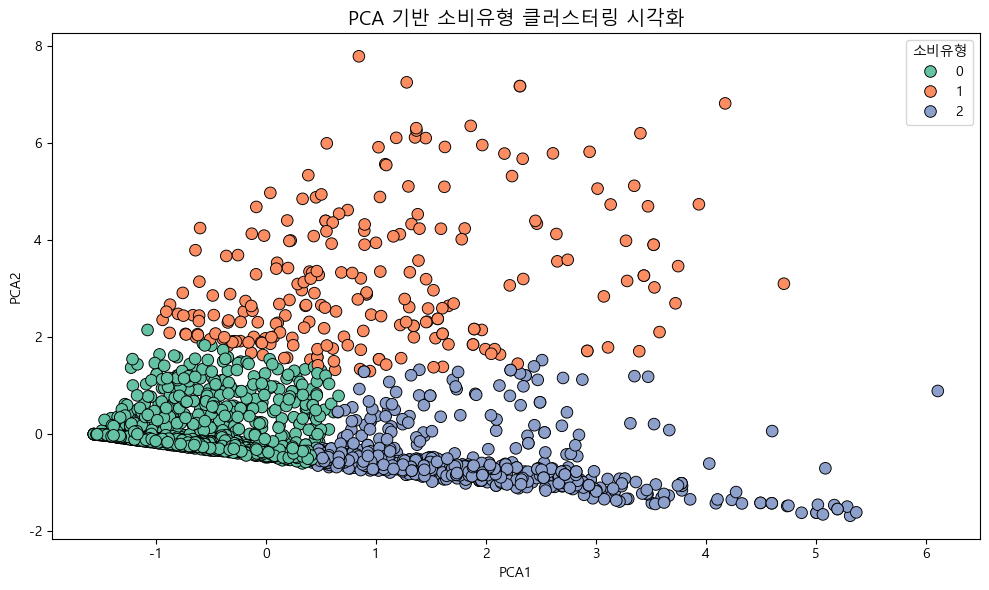

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. 사용할 변수 설정 (전체결제금액은 제외)
features = ['교통결제금액', '활동결제금액', '사전결제금액']

# 2. NaN 처리 및 이상치 제거 (상위 1% 제거)
X = all_merge[features].fillna(0)
X = X[(X < X.quantile(0.99)).all(axis=1)]

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. KMeans 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 클러스터 결과 저장
X['소비유형'] = clusters

# 5. PCA (2차원 축소)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 6. PCA 결과 DataFrame 생성
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['소비유형'] = clusters


X['소비유형'] = clusters
summary = X.groupby('소비유형')[['교통결제금액', '활동결제금액', '사전결제금액']].mean()
display(summary)

# 7. 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='소비유형',
    palette='Set2',
    s=70, edgecolor='black'
)
plt.title('PCA 기반 소비유형 클러스터링 시각화', fontsize=14)
plt.legend(title='소비유형')
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

day_mean = day_trip['전체결제금액'].mean()
lodg_mean = lodgment['전체결제금액'].mean()

print(day_mean)
print(lodg_mean)


mean_df = pd.concat([day_mean, lodg_mean], axis=1).T

# Melt해서 boxplot처럼 barplot 가능하도록 변환
melted = mean_df.reset_index().melt(id_vars='index', var_name='결제항목', value_name='금액')
melted = melted.rename(columns={'index': '숙박여부'})

# Barplot 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='결제항목', y='금액', hue='숙박여부')
plt.title('숙박 여부에 따른 항목별 평균 결제금액 비교')
plt.ylabel('평균 결제금액')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

124161.35800770501
150815.8098417045


TypeError: cannot concatenate object of type '<class 'numpy.float64'>'; only Series and DataFrame objs are valid